In [55]:
from cProfile import label
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.image as pmimg
import numpy as np
import nibabel as nib
import skimage.io as io
import skimage.transform as trans
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import tensorflow as tf
import os.path

approot = ""
try:
    approot = os.path.dirname(os.path.abspath(__file__))
except NameError: # We are in a jupyter notebook
    approot = os.getcwd()

# just going to data folder in order to load all dicom
os.chdir(str(approot))
print(str(approot))

c:\Users\abarb\Documents\GitHub\abdomen_segmentation


In [56]:
# Fonctions utiles

# affichage d'image
def fast_display(*img2dlst):
    plt.figure(figsize=(24, 12))
    nbImg = len(img2dlst)
    cols = min(9, nbImg)
    rows = (nbImg // cols) + 1
    for jaaj, img2d in enumerate(img2dlst):
        plt.subplot(rows, cols, jaaj + 1)
        plt.imshow(img2d)
    plt.show()

# affichage slice
def print_slices(img):
    sx, sy, sz = img.shape
    fast_display(img[sx//2, :, :], img[sy//2, :, :], img[sz//2, :, :])

# calcul des différences entre 2 images (dice)
def compute_dice(X, Y):
    Xbin = (X > 0)
    Ybin = (Y > 0)
    cardIntersec = np.sum(np.logical_and(Xbin, Ybin))
    cardX = np.sum(Xbin)
    cardY = np.sum(Ybin)
    print("cardIntersec = ", cardIntersec)
    print("cardX = ", cardX)
    print("cardY = ", cardY)
    if cardX + cardY > 0:
        dice = (2.0 * cardIntersec)/(cardX + cardY)
        print("dice = ", dice)
        return dice
    else:
        return 0

# normalisation des valeurs dans une image (pas besoin car déjà normalisées ici)
def normalisation(img):
    nu = np.mean(img[img > 0])
    sigma = np.std(img[img > 0])
    return ((img - nu)/sigma)

Data shape is : (192, 156, 12)
Label shape is : (192, 156, 12)
Data : ./data/training/DET0000101_avg.nii.gz


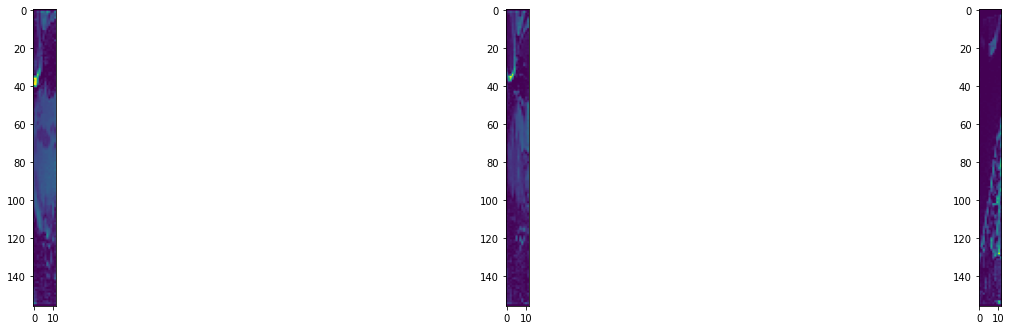

Label : ./data/training_labeled/DET0000101_avg_seg.nii.gz


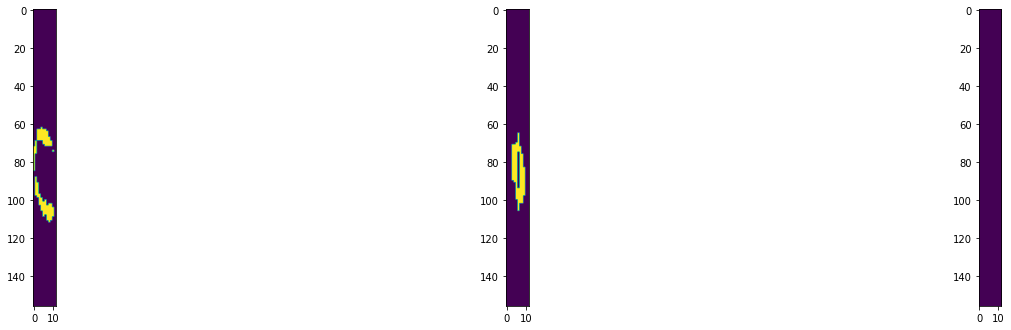

Nb patients : 83


In [57]:
# On a 83 abdomens labelisés au total, on doit les séparer en train, validation, test

total_patients = 0
unlabeled_data = []
labeled_data = []
for _, _, filenames in os.walk("./data/training_labeled"):
    for filename in filenames:

        if 'manifest' in filename or filename[0] == '.':
            continue

        name = "./data/training/" + filename[:-11] + ".nii.gz"
        data = nib.load(name).get_fdata()
        name_label = "./data/training_labeled/" + filename
        data_label = nib.load(name_label).get_fdata()
        unlabeled_data.append(data)
        labeled_data.append(data_label)

        if total_patients == 0:
            print("Data shape is : " + str(data.shape))
            print("Label shape is : " + str(data_label.shape))
            print("Data : " + name)
            print_slices(data)
            print("Label : " + name_label)
            print_slices(data_label)
        
        #print(filename + " : " + name)
        total_patients += 1

print("Nb patients : " + str(total_patients))